In [74]:
%pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [75]:
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [76]:
# define the error functions
def mean_absolute_percentage_error(t_true, y_predict):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)
    """
    t_true, y_predict = np.array(t_true), np.array(y_predict)
    return np.mean(np.abs((t_true - y_predict) / t_true)) * 100

In [77]:
#import the dataset
data_frame = pd.read_csv("../../../data/file.csv")
data_frame.head()

,Series ID,Year,Period,Label,Value
0,WPU102302,1960,M01,1960 Jan,37.7
1,WPU102302,1960,M02,1960 Feb,37.7
2,WPU102302,1960,M03,1960 Mar,37.3
3,WPU102302,1960,M04,1960 Apr,36.9
4,WPU102302,1960,M05,1960 May,34.7


In [78]:
# evaluating the dataset before doing the xgboos trainin g of the data
data_frame.info()
# check for missing values
null_count = data_frame.isnull().sum()
print("Missing values in each column:\n", null_count)
# check for duplicates
duplicates_counts = data_frame.duplicated().sum()
print("Number of duplicate rows:", duplicates_counts)
# check the data types
data_frame.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Series ID  784 non-null    object 
 1   Year       784 non-null    int64  
 2   Period     784 non-null    object 
 3   Label      784 non-null    object 
 4   Value      784 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 30.8+ KB
Missing values in each column:
 Series ID    0
Year         0
Period       0
Label        0
Value        0
dtype: int64
Number of duplicate rows: 0


Series ID     object
Year           int64
Period        object
Label         object
Value        float64
dtype: object

In [79]:
#filter data only for the last 10 years
data_frame = data_frame[data_frame['Year'] >= 2000]

In [80]:
# Extract month number from Period column (M01 -> 1, M12 -> 12)
data_frame['Month'] = data_frame['Period'].str.extract('M(\\d+)').astype(int)

# Create a proper datetime index
data_frame['Date'] = pd.to_datetime(data_frame[['Year', 'Month']].assign(Day=1))

In [81]:
# plotting the data to understand the trends and other components
ts_data = data_frame.set_index('Date')['Value']

# Display information about the time series
print(f"Time series ranges from {ts_data.index.min().strftime('%Y-%m-%d')} to {ts_data.index.max().strftime('%Y-%m-%d')}")
print(f"Number of data points: {len(ts_data)}")
print(f"Min value: {ts_data.min()}, Max value: {ts_data.max()}, Mean value: {ts_data.mean():.2f}")

# Show the first and last few values
print("\nFirst few values:")
print(ts_data.head())
print("\nLast few values:")
print(ts_data.tail())

Time series ranges from 2000-01-01 to 2025-04-01
Number of data points: 304
Min value: 132.4, Max value: 357.652, Mean value: 222.18

First few values:
Date
2000-01-01    186.2
2000-02-01    193.4
2000-03-01    192.6
2000-04-01    181.0
2000-05-01    173.0
Name: Value, dtype: float64

Last few values:
Date
2024-12-01    315.277
2025-01-01    319.281
2025-02-01    326.443
2025-03-01    354.496
2025-04-01    350.272
Name: Value, dtype: float64


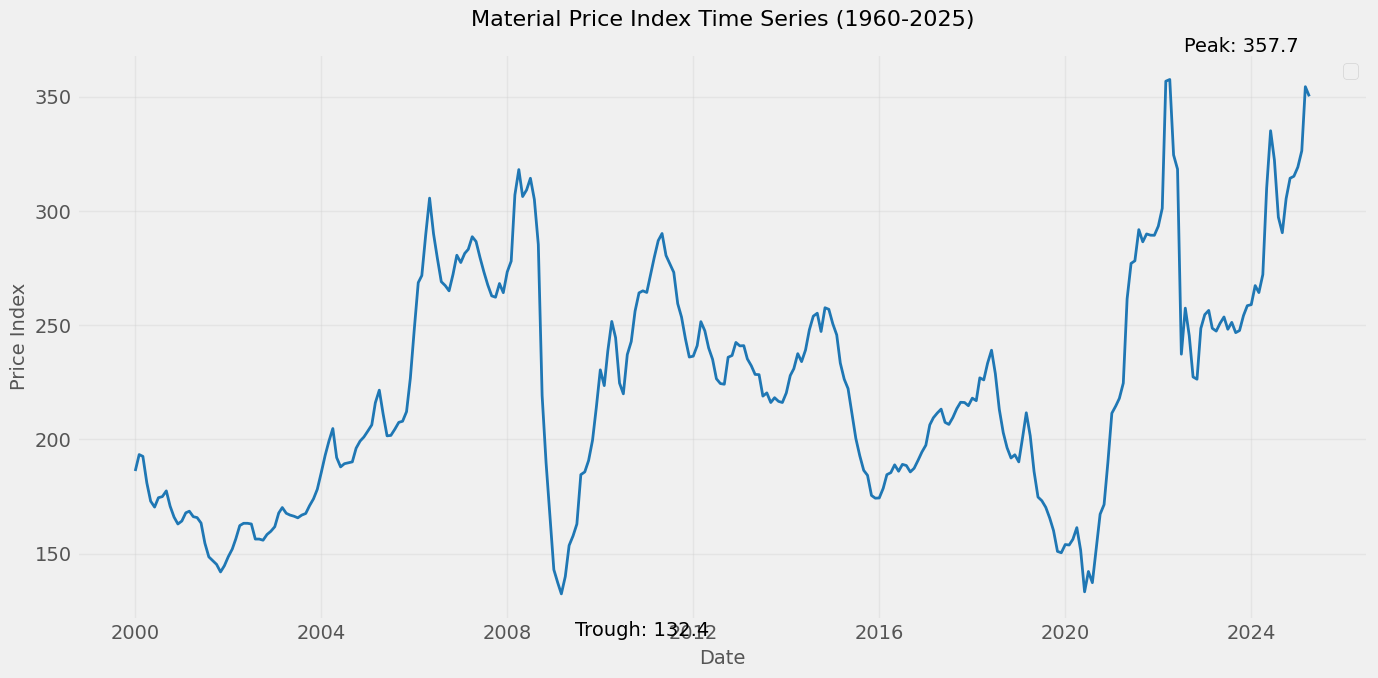

In [82]:
data_frame = data_frame.set_index("Label")

# Create a proper time series plot
plt.figure(figsize=(14, 7))
plt.plot(ts_data.index, ts_data.values, color='#1f77b4', linewidth=2)

# Enhance the plot with proper labels and formatting
plt.title('Material Price Index Time Series (1960-2025)', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price Index', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Add annotations for significant peaks or troughs
top_peak = ts_data.idxmax()
bottom_trough = ts_data.idxmin()

plt.annotate(f'Peak: {ts_data.max():.1f}', 
            xy=(top_peak, ts_data.max()),
            xytext=(10, 20),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.annotate(f'Trough: {ts_data.min():.1f}', 
            xy=(bottom_trough, ts_data.min()),
            xytext=(10, -30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-.2'))

plt.tight_layout()
plt.show()

In [83]:
# feature engineering
# creating a lag feature for the target variable
# Creating lag features for time-series data
def create_lag_features(data, lag_steps=1):
    for i in range(1, lag_steps + 1):
       data[f'lag_{i}'] = data['Value'].shift(i)
    return data
# Applying lag feature creation to the dataset
data_frame = create_lag_features(data_frame, lag_steps=3)

# creating a rolling mean feature
def create_rolling_mean(data, window_size=3):
    data['rolling_mean'] = data['Value'].rolling(window=window_size).mean()
    return data
# Applying rolling mean feature creation to the dataset
data_frame = create_rolling_mean(data_frame, window_size=3)

# adding a fourior transformer feature
def apply_fourier_transformation(data_frame):
    values = data_frame['Value'].values
    fourier_transformed = fft(values)
    data_frame['fourier_transformed'] = np.abs(fourier_transformed)
    return data_frame
# applying Fourier transformation to the dataset
data_frame = apply_fourier_transformation(data_frame)  

In [84]:
data_frame.head()

,Series ID,Year,Period,Value,Month,Date,lag_1,lag_2,lag_3,rolling_mean,fourier_transformed
Label,,,,,,,,,,,
2000 Jan,WPU102302,2000,M01,186.2,1,2000-01-01,NaN,NaN,NaN,NaN,67542.636000
2000 Feb,WPU102302,2000,M02,193.4,2,2000-02-01,186.2,NaN,NaN,NaN,1251.600839
2000 Mar,WPU102302,2000,M03,192.6,3,2000-03-01,193.4,186.2,NaN,190.733333,4933.073180
2000 Apr,WPU102302,2000,M04,181.0,4,2000-04-01,192.6,193.4,186.2,189.000000,5315.140467
2000 May,WPU102302,2000,M05,173.0,5,2000-05-01,181.0,192.6,193.4,182.200000,2676.812490


In [85]:
# splitting the dataset into train and test sets
train_data = data_frame[data_frame['Date'] < '2024-12-31']
test_data = data_frame[data_frame['Date'] >= '2024-12-31']

In [86]:
model = XGBRegressor()
# training the model
model.fit(train_data[['Year','Month','lag_1','lag_2','lag_3', 'rolling_mean', 'fourier_transformed']], train_data['Value'])
#TODO: need to make the dataset as a supervised learning dataset - lag feature is already created
# lag features can be used for fitting the model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
